# RUSTY BARGAIN. Predicciones de precios de automóviles

## Contenido <a id='back'></a>

* [Introducción](#intro) 
* [1. Preparación de datos](#data_review)
* [2. Entrenamiento del Modelo](#trainning)
* [3. Análisis del modelo](#analysis)
* [Conclusiones](#end)

## Introducción <a id='intro'></a>

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche para crear un modelo que determine el valor de mercado.

## Objetivos

A Rusty Bargain le interesa:

- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento

[Regresar a contenido](#back)

## 1. Preparación de datos <a id='data_review'></a>

In [1]:
pip install lightgbm


In [2]:
pip install xgboost

In [3]:
pip install catboost

In [4]:
# Se importa las librerías que utilizaremos

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xg
import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import time
import matplotlib.pyplot as plt 

In [5]:
# Cargamos los datos

df = pd.read_csv('car_data.csv')


In [6]:
df.head()

In [7]:
df.info()

In [8]:
df.isna().sum()

In [9]:
df['Model'].value_counts()

Podemos obserbar que una de las columnas que tiene datos ausentes es la de modelos de autos, sin embargo, se analizó el los modelos por 'brand', pero las marcas tienen diferentes modelos y no hay alguna forma de determinar que modelos son cada uno de los datos ausentes, a  parte que no es eficiente el analizar modelo por modelo y marca por marca, por lo que se determinó que los datos ausentes de los modelos se categorizarían en 'other', en donde se revisó hay diferentes marcas de este modelo.

In [10]:
df['Model']=df['Model'].fillna('other')

In [11]:
df['Model'].isna().sum()

In [12]:
#Se analizan las dos columnas por las que se podría categorizar los dtos ausentes
df['Model'].value_counts().head(15)

In [13]:
df['Brand'].value_counts().head(15)

In [14]:
df['FuelType'].value_counts()

In [15]:
df['VehicleType'].value_counts()

Podemos observar que en la columna 'Brand' tiene categorías con mayor número de datos, por lo que se determinarán las modas condicionados  en las diferentes columnas que contienen datos ausentes. sin embargo, no tendríamos predicciones más específicas, por lo que se realizaran por los modelos de los autos.

In [16]:
df[df['Model']=='golf'].isna().sum()

In [17]:
df[df['Model']=='golf']['VehicleType'].value_counts()

In [18]:
df[df['Model']=='golf']['Gearbox'].value_counts()

In [19]:
df[df['Model']=='golf']['FuelType'].value_counts()

In [20]:
df[df['Model']=='golf']['NotRepaired'].value_counts()

In [21]:
# Se sustituyen los datos ausentes con la moda de cada una de las columnas

df['VehicleType']=df[df['Model']=='golf']['VehicleType'].fillna('sedan')
df['FuelType']=df[df['Model']=='golf']['FuelType'].fillna('petrol')

In [22]:
df[df['Model']=='golf'].isna().sum()

En este caso podemos observar que tanto los datos de la columna 'Gearbox' y 'NotRepaired' son datos booleanos, ya que solo tienen dos categorías, sin embargo, en este caso solamente hay dos opciones y hablando comercialmente datos como la caja de velocidades ('Gearbox') y si ya fue reparado ('Notrepaired') debido a que no se sabe si tiene una falla importante, por lo que no se recomienda que  se rellene con al gún valor que tenemos y se decide que tengan otra categoría.

In [23]:
df[df['Model']=='other']['VehicleType'].value_counts()

In [24]:
df[df['Model']=='other']['Gearbox'].value_counts()

In [25]:
df[df['Model']=='other']['FuelType'].value_counts()

In [26]:
df[df['Model']=='other']['NotRepaired'].value_counts()

In [27]:
df[df['Model']=='3er']['VehicleType'].value_counts()

In [28]:
df[df['Model']=='3er']['Gearbox'].value_counts()

In [29]:
df[df['Model']=='3er']['FuelType'].value_counts()

In [30]:
df[df['Model']=='3er']['NotRepaired'].value_counts()

In [31]:
df[df['Model']=='3er']

Podemos observar que para el vehículo 3er de BMW no hay datos de tipo de vehículo ni tipo de combustible por lo que se investigó que es gasolina y podría rellenar con esos datos, sin embargo siguiendo la moda condicionada se rellenará con 'petrol' ya que todos los datos son ausentes se uede considerar esa categoría 

In [32]:
df[df['Model']=='polo']['VehicleType'].value_counts()

In [33]:
df[df['Model']=='polo']['Gearbox'].value_counts()

In [34]:
df[df['Model']=='polo']['FuelType'].value_counts()

In [35]:
df[df['Model']=='polo']['NotRepaired'].value_counts()

In [36]:
df[df['Model']=='polo']

In [37]:
df[df['Model']=='corsa']['VehicleType'].value_counts()

In [38]:
df[df['Model']=='corsa']['Gearbox'].value_counts()

In [39]:
df[df['Model']=='corsa']['FuelType'].value_counts()

In [40]:
df[df['Model']=='corsa']['NotRepaired'].value_counts()

In [41]:
df[df['Model']=='corsa']

In [42]:
df[df['Model']=='astra']['VehicleType'].value_counts()

In [43]:
df[df['Model']=='astra']['Gearbox'].value_counts()

In [44]:
df[df['Model']=='astra']['FuelType'].value_counts()

In [45]:
df[df['Model']=='astra']['NotRepaired'].value_counts()

In [46]:
df[df['Model']=='astra']

In [47]:
df[df['Model']=='passat']['VehicleType'].value_counts()

In [48]:
df[df['Model']=='passat']['Gearbox'].value_counts()

In [49]:
df[df['Model']=='passat']['FuelType'].value_counts()

In [50]:
df[df['Model']=='passat']['NotRepaired'].value_counts()

In [51]:
df[df['Model']=='passat']

Hasta este punto, podemos observar que en los modelos de autos con el número de datos mayor a 10000 podemos observar que la moda condicional es la misma en todos los casos, por lo quepodemos rellenar el resto de estos datos con estos valores, de igual manera la columna 'NotRepaired' los datos booleanos de si o no, por lo que en este caso podemos sustituir los valores por no.

In [52]:
df['VehicleType']=df['VehicleType'].fillna('sedan')
df['FuelType']=df['FuelType'].fillna('petrol')
df['NotRepaired']=df['NotRepaired'].fillna('no')

In [53]:
df.isna().sum()

Como podemos observar solamente tenemos datos ausentes en los datos de la columna 'Gearbox', ya que una característica como la caja de velocidades es un factor importante para muchos clientes para poder comprar un vahículo y también para definir el precio del vahículo, por loq ue este factor si sería importante crear una nueva categoría.

In [54]:
df['Gearbox'].value_counts()

In [55]:
df= df.fillna('Unknown')
df.info()

In [56]:
df.isna().sum()

In [57]:
df

In [58]:
df['VehicleType'].value_counts()

In [59]:
#df['VehicleType']= df['VehicleType'].fillna('NA')
df['VehicleType'].value_counts()

In [60]:
#df['Gearbox']= df['Gearbox'].fillna('NA')
df['Gearbox'].value_counts()

In [61]:
#df['VehicleType']= df['VehicleType'].fillna('NA')
df['Model'].value_counts()

In [62]:
#df['VehicleType']= df['VehicleType'].fillna('NA')
df['NotRepaired'].value_counts()

In [63]:
# Verificamos que no hayan datos duplicados 

df.duplicated().sum()

In [64]:
df= df.drop_duplicates().reset_index(drop=True)
df.info()

In [65]:
# Cambiamos el tipo de datos de las fechas de la columna 'DateCrawled' al tipo datetime

df['DateCrawled']=pd.to_datetime(df['DateCrawled'],format= '%d/%m/%Y %H:%M')
df['DateCreated']=pd.to_datetime(df['DateCreated'],format= '%d/%m/%Y %H:%M')
df['LastSeen']=pd.to_datetime(df['LastSeen'],format= '%d/%m/%Y %H:%M')
df.head()

In [66]:
df_ohe = pd.get_dummies(df.drop(columns = ['Model'], axis=1), drop_first=True)
df_ohe.head()

In [67]:
df_ohe.info()

Se cambió el tipo de datos de las fechas a datetime, se elimnaron datos duplicados, por lo que con este tratamiento se considera ya están listos para realizar el análisis y operaciones para el proyecto.

In [68]:
df_ohe.describe()

Podemo sobservar que en la columna de precios, a;os de registro, potencia y año de registro, en donde se observan datos inconcistentes y atípicos.

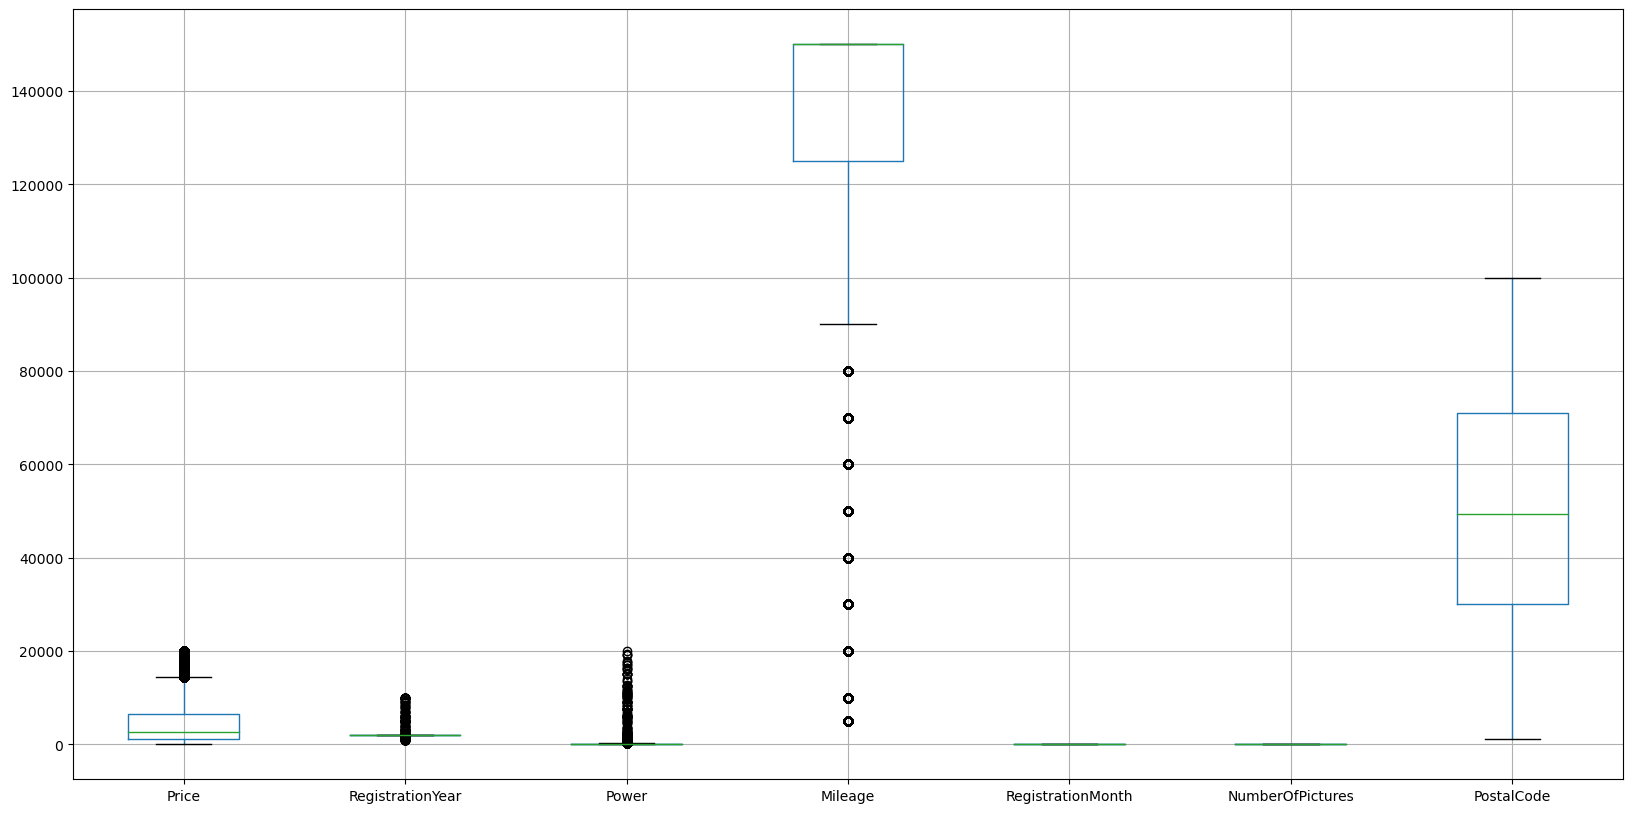

In [69]:

df.boxplot(figsize=(20,10))

In [70]:

def down_limit(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    iqr= q3-q1
    down= q1-(1.5*iqr)
    return down
    
def up_limit(data):
    q1=data.quantile(0.25)
    q3=data.quantile(0.75)
    iqr= q3-q1
    up= q3+(1.5*iqr)
    return up   

In [71]:
down_limit(df_ohe['Price'])

Se considera utilizar métricas  estadísticas para eliminar los datos atípicos e inconcistentes, sin embargo, en el caso de Precios los valores acptados inlcuyen los precios de 0 euros, ya que un auto no puede tener un precio de 0 euros. Sin embargo, buscando en internet se comenzaron a entrar venta de autos a partir de los 400 euros, por lo que se considera un precio medio de esto que será 200 euros, con la intensión de perder la menor cantidad de datos.

In [72]:
df_ohe[df_ohe['Price']<200]

In [73]:
df_ohe[df_ohe['Price']<=400]['Price'].value_counts()

In [74]:
df_ohe[df_ohe['Price']<=100]['Price'].value_counts()

In [75]:
down_limit(df_ohe['Power'])

In [76]:
df_ohe[df_ohe['Power']<df_ohe['Power'].quantile(0.25)]

In [77]:
df_ohe[df_ohe['Power']<=df_ohe['Power'].quantile(0.25)]['Power'].value_counts().head(50)

Podemos observa que la potencia tiene valores de cero lo cual nos indica que no podemos vender un auto con esta potencia, aparte que analizando los datos, podemos observar que los autos reportados en los datos con potencia 0 es de 40 mil y si ponemos como lkímite inferior el primer cuartil, ódemos observar que se perdería 88 mil datos, sin embargo, se ha encontrado que algunos autos pequeños pueden llegar a tener hasta 40 CV, por lo que utilizaremos este valor como límite inferior 

In [78]:
df_ohe[df_ohe['Power']<40]

In [80]:
# Se eliminan los datos atípicos

df_ohe=df_ohe[
    (200 <= df_ohe['Price'])
    & (df_ohe['Price'] <= up_limit(df_ohe['Price']))
    & (down_limit(df_ohe['RegistrationYear']) <= df_ohe['RegistrationYear'])
    & (df_ohe['RegistrationYear'] <= up_limit(df_ohe['RegistrationYear']))
    &(40 <= df_ohe['Power'])
    & (df_ohe['Power'] <= up_limit(df_ohe['Power']))
    &(1 <= df_ohe['RegistrationMonth'])
    & (df_ohe['RegistrationMonth'] <= 12) 
]

/Users/carlosortiz/Documents/bases

In [81]:
df_ohe

In [82]:
df_ohe.describe()

In [83]:
df_ohe.info()

[Regresar a contenido](#back)

## 2. Entrenamiento del modelo <a id='trainning'></a>

In [84]:
# Se establecen las variables de features y target
features = df_ohe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_ohe['Price']

In [85]:
# Se separan los datos en los tres grupos : entrenamiento, validación y prueba

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.3, random_state=12345)


In [86]:
# Se prueba elmodelo de ábol de decisión

for depth_tree in range (8,15):
    model_tree_train= DecisionTreeRegressor(max_depth=depth_tree, random_state=12345)
    model_tree_train.fit(features_train, target_train)

    predictions_valid_tree_train = model_tree_train.predict(features_valid)
    
    mse_tree_train = mean_squared_error(target_valid, predictions_valid_tree_train)
    rmse_tree_train = mse_tree_train**0.5

    r2_tree_train =r2_score(target_valid, predictions_valid_tree_train)

    eam_tree_train= mean_absolute_error(target_valid, predictions_valid_tree_train)

    print('Depth', depth_tree, ', RMSE= ', rmse_tree_train, ', R2= ', r2_tree_train, ', EAM= ', eam_tree_train )

    

In [87]:
# Se prueba el modelo de bosque aleatorio

for depth_forest in range (18,22):
    model_forest_train= RandomForestRegressor(n_estimators=20, max_depth=depth_forest, random_state=12345)
    model_forest_train.fit(features_train, target_train)

    predictions_valid_forest_train = model_forest_train.predict(features_valid)

    mse_forest_train = mean_squared_error(target_valid, predictions_valid_forest_train)
    rmse_forest_train = mse_forest_train**0.5

    r2_forest_train=r2_score(target_valid, predictions_valid_forest_train)

    eam_forest_train= mean_absolute_error(target_valid, predictions_valid_forest_train)

    print('Depth', depth_forest, ', RMSE= ', rmse_forest_train, ', R2= ', r2_forest_train, ', EAM= ', eam_forest_train )




In [ ]:
# Se prueba el modelo de regresion lineal

model_lineal = LinearRegression()

model_lineal.fit(features_train, target_train)

predictions_valid_lineal = model_lineal.predict(features_valid)

mse_lineal = mean_squared_error(target_valid, predictions_valid_lineal)
rmse_lineal = mse_lineal**0.5

r2_lineal=r2_score(target_valid, predictions_valid_lineal)

eam_lineal= mean_absolute_error(target_valid, predictions_valid_lineal)

print( 'RMSE= ', rmse_lineal, ', R2= ', r2_lineal, ', EAM= ', eam_lineal )

In [ ]:
# Se prueba el modelo de LightGBM 

best_mse_clf =10000
best_leaves_clf = 0
best_msg_clf = 0
best_rmse_clf = 0
best_r2_clf = 0
best_eam_clf = 0

for leaves_clf in range (90,100):
    
    for msg_clf in range (0,10):

        model_clf_train = lgb.LGBMRegressor(num_leaves =leaves_clf , min_split_gain = msg_clf)
        model_clf_train.fit(features_train, target_train)

        valid_pred_clf_train=model_clf_train.predict(features_valid)


        mse_clf_train = mean_squared_error(target_valid, valid_pred_clf_train)
        rmse_clf_train = mse_clf_train**0.5

        r2_clf_train=r2_score(target_valid, valid_pred_clf_train)

        eam_clf_train= mean_absolute_error(target_valid, valid_pred_clf_train)

        if mse_clf_train < best_mse_clf :
            best_leaves_clf = leaves_clf
            best_msg_clf = msg_clf
            best_rmse_clf = rmse_clf_train
            best_r2_clf = r2_clf_train
            best_eam_clf = eam_clf_train
            
print('Para LightGBM, los mejores parámetros son Leaves=', leaves_clf , ', min_split_gain=', msg_clf ,', RMSE es: ', rmse_clf_train, ', R2 =', r2_clf_train, ', EAM =', eam_clf_train )

In [ ]:
# Se prueba el modelo de XGBoost

best_mse_xg =10000
best_rmse_xg = 0
best_estimators_xg = 0
best_seed_xg = 0
best_rmse_xg = 0
best_eam_xg = 0

for estimators_xg in range (80,100):
    
    for seed_xg in range (1,10):

        model_xg_train= xg.XGBRegressor(n_estimators= estimators_xg, seed= seed_xg)

        model_xg_train.fit(features_train, target_train)

        valid_pred_xg_train=model_xg_train.predict(features_valid)


        mse_xg_train = mean_squared_error(target_valid, valid_pred_xg_train)
        rmse_xg_train = mse_xg_train**0.5

        r2_xg_train=r2_score(target_valid, valid_pred_xg_train)

        eam_xg_train= mean_absolute_error(target_valid, valid_pred_xg_train)

        if mse_xg_train < best_mse_xg :
            best_rmse_xg = rmse_xg_train
            best_estimators_xg = leaves_clf
            best_seed_xg = msg_clf
            best_rmse_xg = rmse_xg_train
            best_eam_xg = r2_xg_train

print('Para XGBoost, los mejores parámetros son n_estimators=', estimators_xg , ', seed=', seed_xg,', RMSE es: ', rmse_xg_train, ', R2 =', r2_xg_train, ', EAM =', eam_xg_train )


In [ ]:
# Se prueba el modelo de CatBoost

for iterations_cat in range (480, 500):
    model_cat_train = cb.CatBoostRegressor(
        loss_function="RMSE", iterations=iterations_cat, random_seed=12345
    ) 

    model_cat_train.fit(features_train, target_train)

    pred_valid_cat_train = model_cat_train.predict(features_valid)
    pred_valid_cat_train

    mse_cat_train = mean_squared_error(target_valid, pred_valid_cat_train)
    rmse_cat_train = mse_cat_train**0.5

    r2_cat_train=r2_score(target_valid, pred_valid_cat_train)

    eam_cat_train= mean_absolute_error(target_valid, pred_valid_cat_train)

    print('Para XGBost','iterations= ', iterations_cat, 'RMSE es: ', rmse_cat_train, ', R2 =', r2_cat_train, ', EAM =', eam_cat_train )



[Regresar a contenido](#back)

## 3. Análisis del modelo <a id='analysis'></a>

In [88]:
%%time
#Se analiza el modelo de ärbol de decisiones con los mejores Hiperparámetros

model_tree= DecisionTreeRegressor(max_depth=12, random_state=12345)
model_tree.fit(features_train, target_train)

predictions_valid_tree = model_tree.predict(features_valid)
    
mse_tree = mean_squared_error(target_valid, predictions_valid_tree)
rmse_tree = mse_tree**0.5

r2_tree=r2_score(target_valid, predictions_valid_tree)

eam_tree= mean_absolute_error(target_valid, predictions_valid_tree)

print( 'RMSE= ', rmse_tree, ', R2= ', r2_tree, ', EAM= ', eam_tree )

In [89]:
%%time
# Se analiza el modelo de bosque aleatorio con los mejores hiperpaámetros

model_forest= RandomForestRegressor(n_estimators=20, max_depth=20, random_state=12345)
model_forest.fit(features_train, target_train)

predictions_valid_forest = model_forest.predict(features_valid)

mse_forest = mean_squared_error(target_valid, predictions_valid_forest)
rmse_forest = mse_forest**0.5

r2_forest=r2_score(target_valid, predictions_valid_forest)

eam_forest= mean_absolute_error(target_valid, predictions_valid_forest)

print(', RMSE= ', rmse_forest, ', R2= ', r2_forest, ', EAM= ', eam_forest )

In [90]:
%%time
# Se analiza el modelo de Regresión Lineal 

model_lineal = LinearRegression()

model_lineal.fit(features_train, target_train)

predictions_valid_lineal = model_lineal.predict(features_valid)

mse_lineal = mean_squared_error(target_valid, predictions_valid_lineal)
rmse_lineal = mse_lineal**0.5

r2_lineal=r2_score(target_valid, predictions_valid_lineal)

eam_lineal= mean_absolute_error(target_valid, predictions_valid_lineal)

print( 'RMSE= ', rmse_lineal, ', R2= ', r2_lineal, ', EAM= ', eam_lineal )

In [91]:
%%time
# Se analiza el modelo de LightGBM 

model_clf = lgb.LGBMRegressor(num_leaves =99 , min_split_gain = 9)
model_clf.fit(features_train, target_train)

valid_pred_lgb=model_clf.predict(features_valid)


mse_lgb = mean_squared_error(target_valid, valid_pred_lgb)
rmse_lgb = mse_lgb**0.5

r2_lgb=r2_score(target_valid, valid_pred_lgb)

eam_lgb= mean_absolute_error(target_valid, valid_pred_lgb)

print('Para LightGBM RMSE es: ', rmse_lgb, ', R2 =', r2_lgb, ', EAM =', eam_lgb )

In [92]:
%%time
# Se analiza el modelo de XGBoost 

model_xg= xg.XGBRegressor(n_estimators= 99, seed= 9)

model_xg.fit(features_train, target_train)

valid_pred_xg=model_xg.predict(features_valid)


mse_xg = mean_squared_error(target_valid, valid_pred_xg)
rmse_xg = mse_xg**0.5

r2_xg=r2_score(target_valid, valid_pred_xg)

eam_xg= mean_absolute_error(target_valid, valid_pred_xg)

print('Para XGBoost RMSE es: ', rmse_xg, ', R2 =', r2_xg, ', EAM =', eam_xg )

In [93]:
%%time
# Se analiza el modelo de CatBoost 

model_cat = cb.CatBoostRegressor(loss_function="RMSE", iterations=500, random_seed=12345) 

model_cat.fit(features_train, target_train)

pred_valid_cat = model_cat.predict(features_valid)

mse_cat = mean_squared_error(target_valid, pred_valid_cat)
rmse_cat = mse_cat**0.5

r2_cat=r2_score(target_valid, pred_valid_cat)

eam_cat= mean_absolute_error(target_valid, pred_valid_cat)

print('Para CatBost', 'RMSE es: ', rmse_cat, ', R2 =', r2_cat, ', EAM =', eam_cat )

[Regresar a contenido](#back)

## Conclusión <a id='end'></a>

Como podemo sobservar, inicialmente se tuvoq ue revisar los dtos cn lo que ibamos a trabajar, en donde pudimos observar que en varias colunas había presecia de datos ausentes, estos datos eran del tipo str y se apreció que se trataba de datos categóricos, por lo que diseño una estrategia donde se creó una nueva categoría para dar a conocer los datos que no se conocen. se revisó datos duplicados y se cambiolos tipos a los correctos en el caso de las fechas.

Se entrenó diferentes modelos de árbol de desiciones, bosque aleatorio y regresión lineal, al igual que se entrenaron los modelo sde potenciación LightGBM, CatBoost y XGBoost, en donde se probaron algunos hiperpaámetros en estos modelos para poder probar su eficiencia el realizar las predicciones de los precios de los automóviles.

Se puede observar que de los tres modelos principales el de de bosque aleatoreo el que tiene mejores predicciones, basandonos en las métricas de calidad,sin embargo, de esos tres es el más tradado.

Mientras que de los métodos de potenciación de gradiente, se puede observar que el que tiene mejores predicciones es el modelo de LightGBM y CatBoost, basandonos en la métricas de calidad, sin embargo la diferencia no es significativa, sin embargo, LightGBM es más rápido para  realizar los calculos de potenciación.

En comparación los modelos clasicos cn los de potenciación, no hay mucha diferencia y se obtienen resultados similares.

[Regresar a contenido](#back)